# **Delivery Dron Analysis**

# **Описание проекта**
Необходимо проанализировать данные о продажах иностранной интернет компании “Delivery Dron”, занимающейся продажей дронов доставщиков и работающей в четырех регионах c мая 2019 года.
# **Задачи**

*   сделать отчет о вложенных средствах
*   построить планы на следующий год
*   выяснить  в какой регион и какой рекламный канал инвестировать больше денег на привлечение клиентов в 2020 году





# **Описание данных**
Файл ecom_yl.csv содержит данные о визитах и покупках пользователей сайта интернет магазина “Delivery Dron”. Каждая строка представляет визит пользователя. Данные отсортированы по Session Date.

Столбцы набора данных:

    0: User Id - id пользователя    
    1: Region - регион визита    
    2: Device - устройство, с которого производится вход на сайт    
    3: Channel - рекламный канал перехода на сайт   
    4: Session Start - время начала пользовательской сессии (входа на сайт)
    5: Session End - время окончания пользовательской сессии (уход с сайта)
    6: SessionDurationSec - длительность сессии в секундах  
    7: Session Date - дата визита  
    8: Month - месяц визита   
    9: Day - день дня недели визита  
    10: Hour of day - час (от 0 до 24) визита    
    11: Order Dt - дата покупки   
    12: Revenue - сумма покупки    
    13: Payment Type - тип оплаты
    14: Promo code - использование промокода на скидку 10% (есть-1, нет-0).


# Шаг 0: Подготовка

## 0.1: Импорт библиотек

In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import warnings

## 0.2: Константы и настройки

In [264]:
warnings.filterwarnings('ignore')

## 0.3: Загрузка данных

In [265]:
df = pd.read_csv("data.csv", sep=",")
df.head()

,User Id,Region,Device,Channel,Session Start,Session End,SessionDurationSec,Session Date,Month,Day,Hour of day,Order Dt,Revenue,Payment Type,Promo code
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN


## 0.4: Пользовательские функции

In [266]:
def get_ohe(data: pd.DataFrame, categories: list):
    '''
    Функция, которая переводит номинальные шкалы в бинарные методом OneHotEncoder.
    '''
    ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
    ohe.fit(data[categories])
    
    temp_df = pd.DataFrame(data=ohe.transform(data[categories]), columns=ohe.get_feature_names_out())
    data = pd.concat([data.reset_index(drop=True), temp_df], axis=1)
    data = data.drop(columns=categories, axis=1)
    return data


def quantitative_analysis(data: pd.DataFrame, factor: str):
    '''
    Функция для анализа категориальных признаков и нахождения супервыбросов. Строит boxplot и hist.
    
    :param data: dataframe
    :param factor: название фактора
    :return: выводит два графика
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    fig.tight_layout()   
    
    sns.histplot(data[factor], kde=True, bins=24, ax=ax1)                    
    sns.boxplot(x=data[factor], ax=ax2)

    ax1.set_xlabel(factor)
    ax2.set_ylabel('Количество')
    
    plt.suptitle(f"Гистограмма и ящик с усами для {factor}", fontsize=22, y=1.01)
    plt.show()
    
    
def get_quantile(data: pd.Series):
    '''
    Функция, которая возвращает границы интерквартильного размаха.
    
    :param data: фактор
    :return: нижняя граница интерквартильного размаха и верхняя
    '''
    # Вычисляем первый и третий квартили
    quantile_1 = data.quantile(0.25)
    quantile_3 = data.quantile(0.75)
    # Вычисляем интерквартильный размах (IQR)
    IQR = quantile_3 - quantile_1
    lower_bound = quantile_1 - 1.5 * IQR
    upper_bound = quantile_3 + 1.5 * IQR
    
    return lower_bound, upper_bound

# **Шаг 1: Общий анализ данных и предобработка**

## 1.0: Колонны
Приведём колонны к формату PEP8 и переименуем некоторые из них.

In [267]:
df.columns = df.columns.str.lower().str.replace(" ", "_")  # PEP8
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             1012 non-null   int64  
 1   region              999 non-null    object 
 2   device              999 non-null    object 
 3   channel             999 non-null    object 
 4   session_start       1012 non-null   object 
 5   session_end         1012 non-null   object 
 6   sessiondurationsec  1012 non-null   float64
 7   session_date        1012 non-null   object 
 8   month               1012 non-null   int64  
 9   day                 1012 non-null   int64  
 10  hour_of_day         1012 non-null   int64  
 11  order_dt            285 non-null    object 
 12  revenue             285 non-null    float64
 13  payment_type        285 non-null    object 
 14  promo_code          285 non-null    float64
dtypes: float64(3), int64(4), object(8)
memory usage: 118.7+

In [268]:
df.columns = df.columns.str.replace("sessiondurationsec", "session_duration_sec")
df.columns = df.columns.str.replace("order_dt", "order_date")
df.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end', 'session_duration_sec', 'session_date', 'month', 'day',
       'hour_of_day', 'order_date', 'revenue', 'payment_type', 'promo_code'],
      dtype='object')

## 1.1: Обработка данных

### region
Уберём опечатки и пустые строки.
Пустые строки необходимо убрать, потому что нам важен регион.
Пропуски могут быть в столбцах, отвечающих за покупку, ведь покупка может быть не совершена.

In [269]:
df["region"].unique()

array(['United States', 'Frаnce', 'Unjted States', 'Germany', 'UK',
       'France', 'Frаncе', 'Franсe', 'germany', nan, 'UК'], dtype=object)

In [270]:
corrections = {
    "Unjted States": "United States",
    "germany": "Germany",
    "Frаncе": "France",
    "UК": "UK",
    "Frаnce": "France",
    "Franсe": "France"
}

df["region"] = df["region"].replace(corrections)
df = df.dropna(subset=['region'])
df["region"].value_counts()

region
United States    679
UK               115
France           103
Germany          102
Name: count, dtype: int64

### device

Уберём опечатки

In [271]:
df["device"].unique()

array(['iPhone', 'PC', 'Mac', 'Android', 'android'], dtype=object)

In [272]:
df["device"] = df["device"].replace("android", "Android")

### channel
Уберем опечатки и поменяем название термина organic на русский "без рекламы"

In [273]:
df["channel"].unique()

array(['социальные сети', 'organic', 'реклама у блогеров',
       'контексная реклама', 'email-рассылки', 'контекстная реклама'],
      dtype=object)

In [274]:
df["channel"] = df["channel"].replace("контексная реклама", "контекстная реклама")
df["channel"] = df["channel"].replace("organic", "без рекламы")

### payment_type
Всё в порядке

In [275]:
df["payment_type"].unique()

array(['Mobile payments', nan, 'Debit card', 'E-wallet', 'Cash',
       'Credit card'], dtype=object)

### session_start, session_end, session_date, order_dt
Переведём тип данных столбцов с датой и временем в соответствующий формат

In [276]:
df['session_start'] = pd.to_datetime(df['session_start'])
df['session_end'] = pd.to_datetime(df['session_end'])
df['session_date'] = pd.to_datetime(df['session_date'])
df['order_date'] = pd.to_datetime(df['order_date'])

### promo_code
Уберем строки, где наличие промокода непонятно (0.862715)

In [277]:
df["promo_code"].value_counts()

promo_code
0.000000    196
1.000000     78
0.862715      3
Name: count, dtype: int64

In [278]:
df = df[(df['promo_code'] == 0) | (df['promo_code'] == 1) | (df['promo_code'].isna())]
# df["promo_code"].astype(int) - NaN не может быть интом

### revenue
Удалим супервыбросы

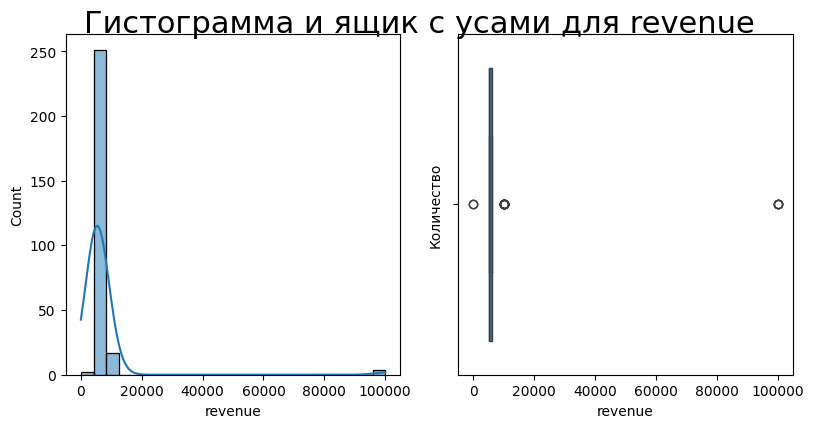

In [279]:
quantitative_analysis(df[df["revenue"].notna()], "revenue")

In [280]:
low, up = get_quantile(df[df["revenue"].notna()]["revenue"])
df = df[((df["revenue"] >= low) & (df["revenue"] <= up)) | (df["revenue"].isna())]
df["revenue"].value_counts()

revenue
4999.0    185
5999.0     66
Name: count, dtype: int64

### Сброс индексов

In [281]:
df.reset_index(drop=True, inplace=True)

## 1.2: Новые метрики

### revenue_with_discount
Итоговая сумма покупки с учетом применения промокода на скидку 10%

In [282]:
df['revenue_with_discount'] = df['revenue'] * (1 - df['promo_code'] * 0.1)
df.head()

,user_id,region,device,channel,session_start,session_end,session_duration_sec,session_date,month,day,hour_of_day,order_date,revenue,payment_type,promo_code,revenue_with_discount
0,601292388085,United States,PC,без рекламы,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaT,NaN,NaN,NaN,NaN
1,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaT,NaN,NaN,NaN,NaN
2,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaT,NaN,NaN,NaN,NaN
3,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaT,NaN,NaN,NaN,NaN
4,271758921583,United States,iPhone,социальные сети,2019-05-02 08:40:35,2019-05-02 08:41:15,40.0,2019-05-02,5,4,8,NaT,NaN,NaN,NaN,NaN


### time_of_day

Временя суток визита

In [283]:
def part_of_day(hour):
    if 6 <= hour < 10:
        return 'morning'
    elif 10 <= hour < 17:
        return 'day'
    elif 17 <= hour < 22:
        return 'evening'
    return 'night'


df['time_of_day'] = df['hour_of_day'].apply(part_of_day)

### payer

столбец с информацией о том, является ли пользователь платящим или нет

In [284]:
df['payer'] = df['revenue'].apply(lambda x: 1 if x > 0 else 0)

## 1.3: Дубликаты

In [285]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

## 1.4: Проверка дат на соотвствие

In [286]:
df = df[(df['order_date'] >= df['session_start']) & (df['order_date'] <= df['session_end']) | (df["payer"] == 0)]
df.reset_index(drop=True, inplace=True)

## Выводы по первому шагу

- Столбы приведены к формату PEP8
- Выявлены и убраны опечатки в категориальных данных
- Убраны пропуски, где необходимо
- Убраны строки с некорректными данными
- Убраны супервыбросы
- Убраны дубликаты
- Перевод данных в соответствующий формат
- Новые метрики

In [287]:
df.head()

,user_id,region,device,channel,session_start,session_end,session_duration_sec,session_date,month,day,hour_of_day,order_date,revenue,payment_type,promo_code,revenue_with_discount,time_of_day,payer
0,601292388085,United States,PC,без рекламы,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaT,NaN,NaN,NaN,NaN,morning,0
1,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaT,NaN,NaN,NaN,NaN,night,0
2,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaT,NaN,NaN,NaN,NaN,evening,0
3,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaT,NaN,NaN,NaN,NaN,day,0
4,271758921583,United States,iPhone,социальные сети,2019-05-02 08:40:35,2019-05-02 08:41:15,40.0,2019-05-02,5,4,8,NaT,NaN,NaN,NaN,NaN,morning,0


# **Шаг 2: Аналитический и графический анализ данных**

### 2.1) Доля продаж по регионам

In [288]:
sales_region = df.groupby('region')['revenue'].sum()
total_sales = df['revenue'].sum()
sales_region_perc = (sales_region / total_sales) * 100
print(sales_region_perc)

region
France            9.458471
Germany           9.305886
UK               11.823069
United States    69.412573
Name: revenue, dtype: float64


### 2.2) Доля продаж по источникам

In [289]:
sales_сhannel = df.groupby('channel')['revenue'].sum()
sales_channel_perc = (sales_сhannel / total_sales) * 100
print(sales_channel_perc)

channel
email-рассылки          2.517183
без рекламы            31.350119
контекстная реклама    16.323390
реклама у блогеров     10.526332
социальные сети        39.282976
Name: revenue, dtype: float64


### 2.3) Доля продаж по устройствам

In [290]:
sales_device = df.groupby('device')['revenue'].sum()
sales_device_perc = (sales_device / total_sales) * 100
print(sales_device_perc)

device
Android    27.154891
Mac        21.281464
PC         17.620128
iPhone     33.943518
Name: revenue, dtype: float64


### 2.4) Количество пользователей с разбивкой на платящих/не платящих по регионам

In [291]:
users_region = df.groupby(['region', 'payer']).size()
users_region = users_region.unstack()
print(users_region)

payer            0    1
region                 
France          78   23
Germany         78   23
UK              83   29
United States  483  174


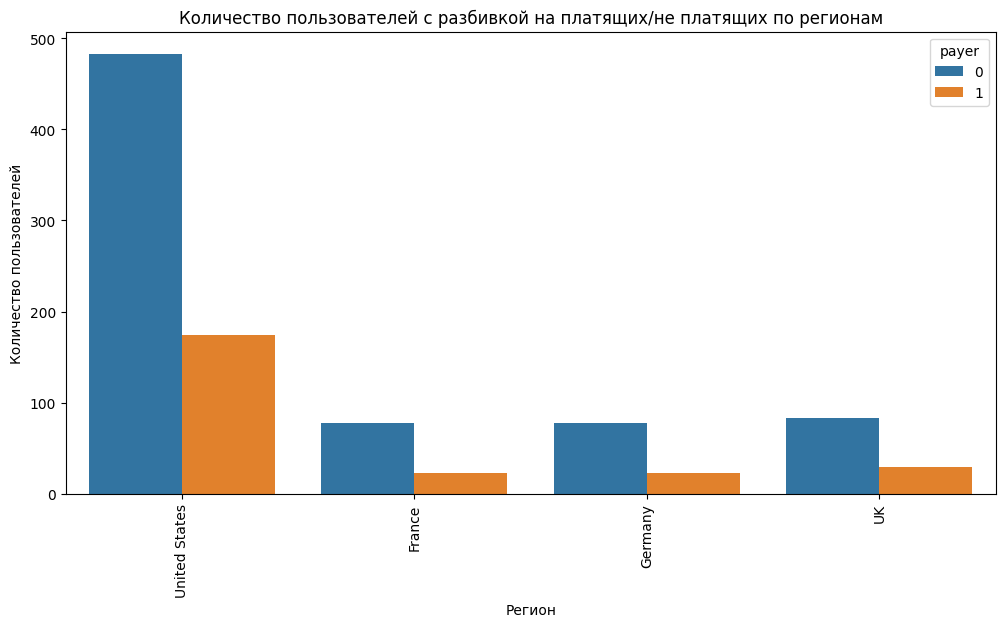

In [292]:
plt.figure(figsize=(12, 6))
sns.countplot(x=df['region'], hue=df['payer'])
plt.title('Количество пользователей с разбивкой на платящих/не платящих по регионам')
plt.xlabel('Регион')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=90)
plt.show()

### 2.5) Количество пользователей с разбивкой на платящих/не платящих по устройствам

In [293]:
users_device = df.groupby(['device', 'payer']).size()
users_device = users_device.unstack()
print(users_device)

payer      0   1
device          
Android  164  67
Mac      142  53
PC       155  44
iPhone   261  85


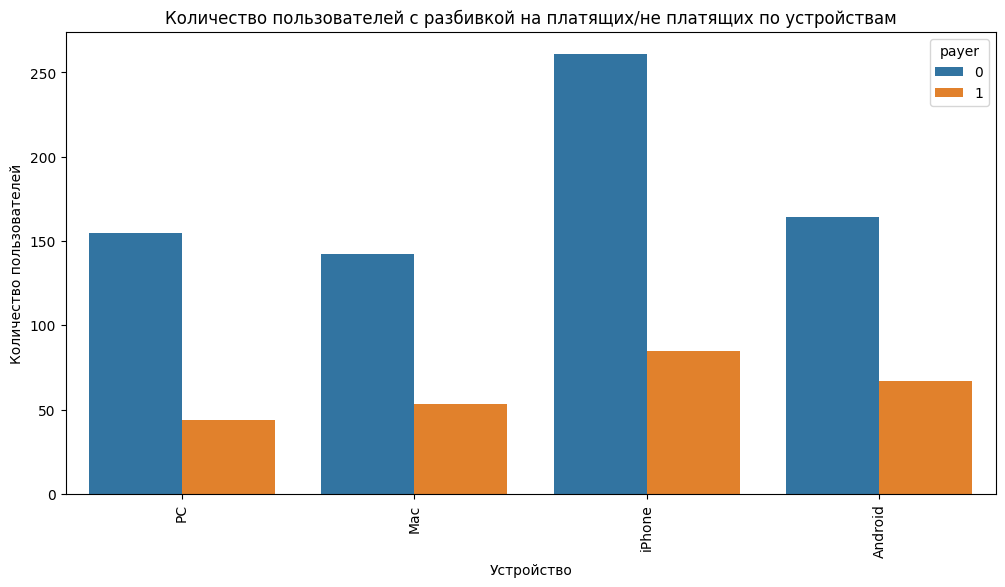

In [294]:
plt.figure(figsize=(12, 6))
sns.countplot(x=df['device'], hue=df['payer'])
plt.title('Количество пользователей с разбивкой на платящих/не платящих по устройствам')
plt.xlabel('Устройство')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=90)
plt.show()


### 2.6) Количество пользователей с разбивкой на платящих/не платящих по источникам

In [295]:
users_channel = df.groupby(['channel', 'payer']).size()
users_channel = users_channel.unstack()
print(users_channel)

payer                  0   1
channel                     
email-рассылки        17   6
без рекламы          259  78
контекстная реклама  117  41
реклама у блогеров    71  26
социальные сети      258  98


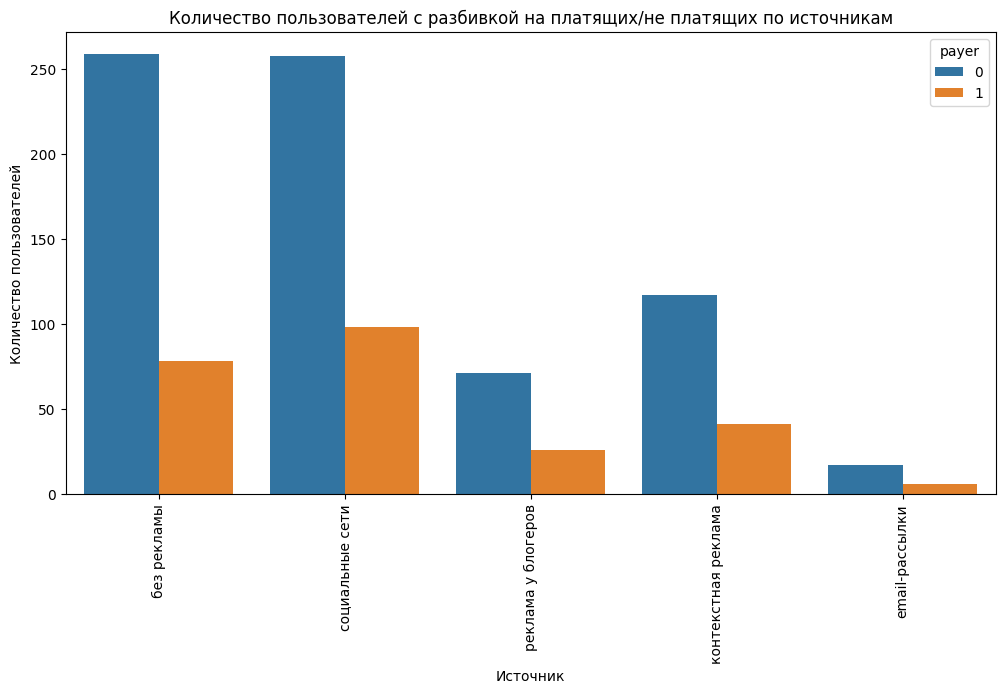

In [296]:
plt.figure(figsize=(12, 6))
sns.countplot(x=df['channel'], hue=df['payer'])
plt.title('Количество пользователей с разбивкой на платящих/не платящих по источникам')
plt.xlabel('Источник')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=90)
plt.show()

### 2.7) График сезонности в продажах по месяцам  

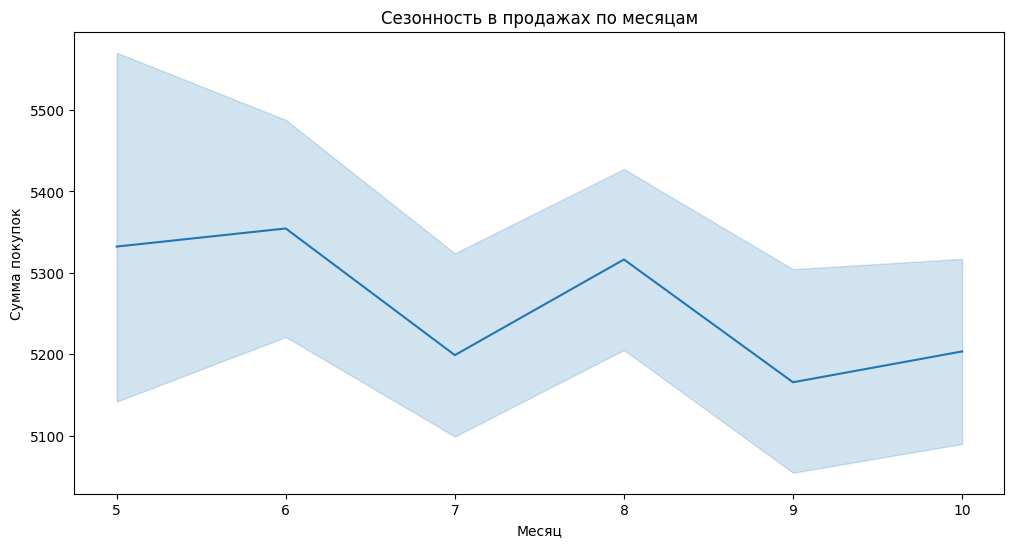

In [297]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='month', y='revenue')
plt.title('Сезонность в продажах по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Сумма покупок')
plt.show()

### 2.8) График сезонности в продажах по дням недели

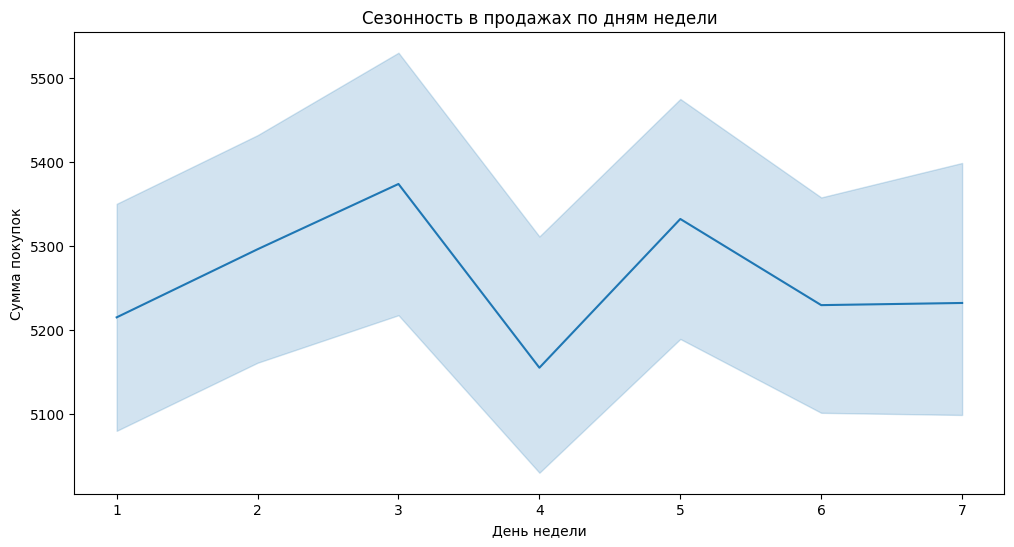

In [298]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='day', y='revenue')
plt.title('Сезонность в продажах по дням недели')
plt.xlabel('День недели')
plt.ylabel('Сумма покупок')
plt.show()

### 2.9) График сезонности в продажах по времени суток

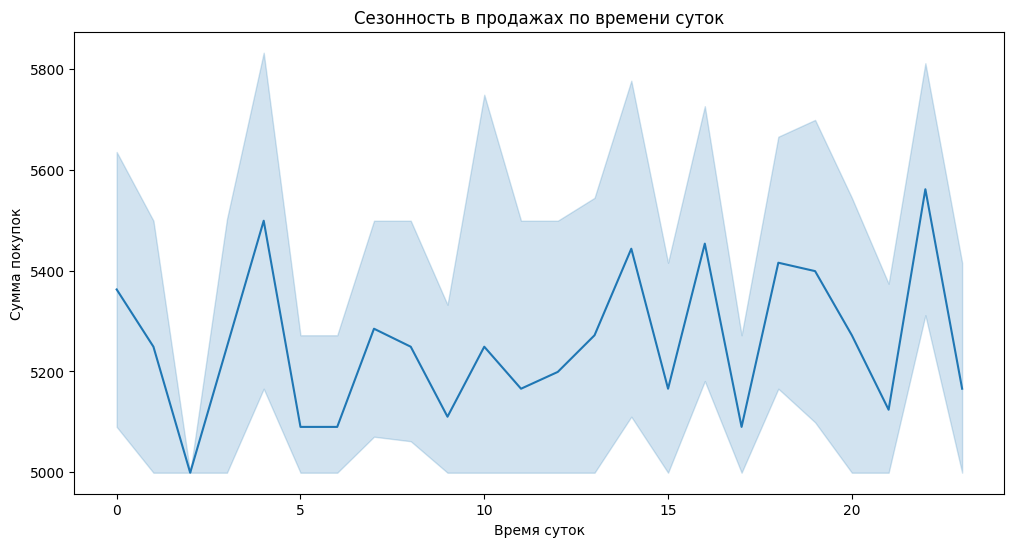

In [299]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='hour_of_day', y='revenue')
plt.title('Сезонность в продажах по времени суток')
plt.xlabel('Время суток')
plt.ylabel('Сумма покупок')
plt.show()

### 2.10) Диаграмма количества покупок по типу оплаты

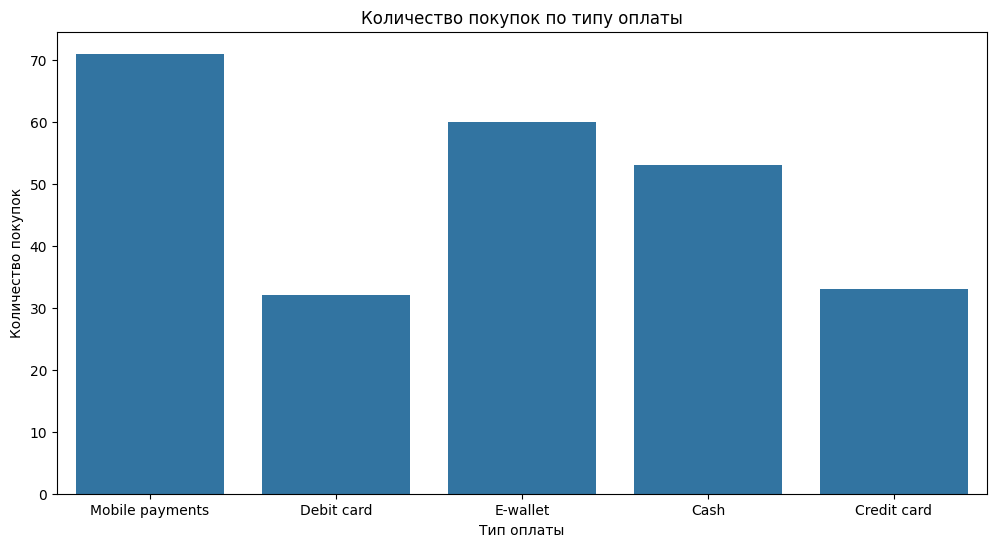

In [300]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='payment_type')
plt.title('Количество покупок по типу оплаты')
plt.xlabel('Тип оплаты')
plt.ylabel('Количество покупок')
plt.show()

# **Шаг 3: Проведение расчетов**

### 3.1) Средний чек

In [301]:
av_check = df['revenue'].mean()
print(av_check)

5264.060240963855


### 3.2) средняя продолжительность сессии по рекламным каналам